In [1]:
import  numpy as np 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgb
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import matplotlib
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


sns.set()
np.random.seed(0)

In [2]:
data_df = pd.read_csv ("Data/CERN/atlas-higgs-challenge-2014-v2.csv")

data_df = data_df.drop(['EventId','Weight' ], axis = 1)  

**metric AMS**

In [3]:
def ams(s, b):
    return np.sqrt(2 * ((s + b + 10) * np.log(1.0 + s/(b + 10)) - s))

def get_ams_score(W, Y, Y_pred):
    s = W * (Y == 1) * (Y_pred == 1)
    b = W * (Y == 0) * (Y_pred == 1)
    s = np.sum(s)
    b = np.sum(b)
    return ams(s, b)

### train data

In [3]:
# KaggleWeight == weight on kaggle data 

In [49]:
training_data  = data_df [ data_df['KaggleSet'] =='t' ].rename({'KaggleWeight' : 'Weight' } , axis = 1 )
training_data = training_data.drop(['KaggleSet' ], axis = 1)

Y_train = ( np.array ( training_data['Label'] ) =='s' ).astype(np.int8)

training_data = training_data.drop([ 'Label' ], axis = 1)  

training_data.head(3)

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight
0,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,...,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653
1,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,125.157,...,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584
2,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,197.814,...,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389


### Test data ( leader board )

In [50]:
ldboard_data  = data_df [ data_df['KaggleSet'] =='b' ].rename({'KaggleWeight' : 'Weight' } , axis = 1 )
ldboard_data = ldboard_data.drop(['KaggleSet' ], axis = 1)

Y_test = ( np.array ( ldboard_data['Label'] ) =='s' ).astype(np.int8)

ldboard_data = ldboard_data.drop([ 'Label' ], axis = 1)  

ldboard_data.head(3)

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight
250000,-999.000,79.589,23.916,3.036,-999.0,-999.0,-999.0,0.903,3.036,56.018,...,98.556,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-0.0,11.246677
250008,70.958,66.329,60.950,0.758,-999.0,-999.0,-999.0,2.370,0.758,66.573,...,102.088,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-0.0,11.500627
250017,40.383,76.439,34.996,59.543,-999.0,-999.0,-999.0,0.900,59.543,81.392,...,196.825,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,2.754413


In [51]:
X_train = training_data.values
X_test  = ldboard_data.values

In [52]:
X_train , X_valid , Y_train , Y_valid = train_test_split( X_train , Y_train , test_size=0.1 , random_state=42 )

In [53]:
X_valid [:,:-1].shape

(25000, 30)

**weights**

In [54]:
# renormalizing the weights for consistency 
W_train = X_train [:,-1] * (1.0/0.9)
W_valid = X_valid [:,-1] * (1.0/0.1)
W_test  = X_test  [:,-1] 


X_train = X_train [:,:-1]
X_valid = X_valid [:,:-1]
X_test  = X_test  [:,:-1]

In [56]:
d_train = lgb.Dataset(X_train, label=Y_train)
# d_valid = lgb.Dataset(X_valid, label=Y_valid , reference=d_train )

In [57]:
# columns = [ training_data.columns[i] for i in range(X_train.shape[-1]) ] 

In [58]:
# param_test ={'num_leaves': sp_randint(6, 50), 
#              'min_child_samples': sp_randint(100, 500), 
#              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
#              'subsample': sp_uniform(loc=0.2, scale=0.8), 
#              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
#              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
#              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

**Model code snippet test**

In [59]:
params = {}
num_round = 100 

params['objective'] = 'binary'
params['metric'] = 'auc'
params['early_stopping_round '] = 5
params['learning_rate'] = 1
clf = lgb.train(params , d_train , num_round )

In [60]:
print ('   - AMS based on Test Data      :',get_ams_score( W_test , Y_test , 
                                                           ( clf.predict ( X_test ) > 0.5 ).astype("int")  ))

   - AMS based on Test Data      : 2.6085242000818822


**learning rate tuning**

In [16]:
num_round = 100 
ls_res = [ ]

lrs =  [ -4 , -3  , -2 , -1 , 0 , 1 , 2 ]
for lr in  lrs  : 
    print(" learning rate : ",10 ** lr)
    params['learning_rate'] = 10 ** lr
    clf = lgb.train(params , d_train , num_round )
    ypred = clf.predict(X_valid)
    res = np.array (precision_recall_fscore_support( Y_valid ,  ( ypred > 0.5 ) .astype(np.int8)   ))[:-1,1]
    ls_res.append (np.array ( [ res[0] , res[1] , res[2] ]) ) 
    print("----------------------------------------------------------------")
    
ls_res = np.array ( ls_res )

 learning rate :  0.0001


C:\Users\raouf\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


----------------------------------------------------------------
 learning rate :  0.001
----------------------------------------------------------------
 learning rate :  0.01
----------------------------------------------------------------
 learning rate :  0.1
----------------------------------------------------------------
 learning rate :  1
----------------------------------------------------------------
 learning rate :  10
----------------------------------------------------------------
 learning rate :  100
----------------------------------------------------------------


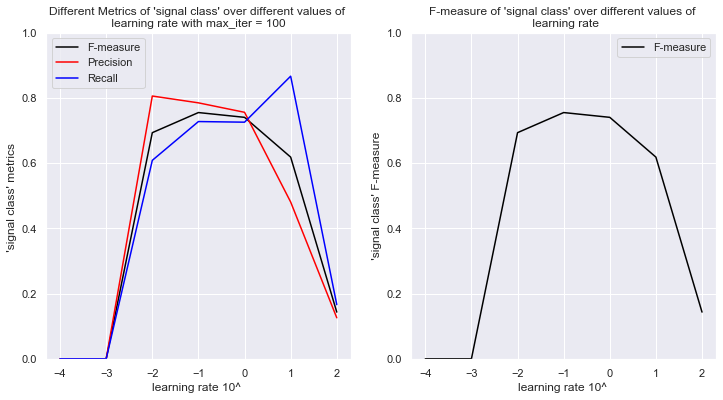

In [17]:
fig , ax = plt.subplots ( nrows = 1 , ncols = 2  , figsize = ( 12 , 6 ) )

ax[0].set_title  ("Different Metrics of 'signal class' over different values of \n learning rate with max_iter = 100 ")
ax[0].set_xlabel("learning rate 10^ ")
ax[0].set_ylabel(" 'signal class' metrics  ")
ax[0].plot   ( lrs , ls_res[:,2] , 'black' , label="F-measure" )
ax[0].plot   ( lrs , ls_res[:,0] , 'red'   , label="Precision" )
ax[0].plot   ( lrs , ls_res[:,1] , 'blue'  , label="Recall" )
ax[0].set_ylim([0,1])
ax[0].legend()

ax[1].set_title  ("F-measure of 'signal class' over different values of \n learning rate")
ax[1].set_xlabel("learning rate 10^ ")
ax[1].set_ylabel(" 'signal class' F-measure ")
ax[1].plot   ( lrs , ls_res[:,2] , 'black' , label="F-measure" )
ax[1].set_ylim([0,1])

ax[1].legend()


plt.show()

In [18]:
params['learning_rate'] = 0.1

**threshold** 

In [21]:
num_round = 100 
ls_res = [ ]
thresholds =  [ 0.2 , 0.3 , 0.4 , 0.5 , 0.6 , 0.7 , 0.8 , 0.9 , 0.99 ]
for th in  thresholds  : 
    print(" threshold : " , th )
    clf = lgb.train(params , d_train , num_round , verbose_eval=False )
    ypred = clf.predict(X_valid)
    ams_valid = get_ams_score( W_valid , Y_valid , ( clf.predict ( X_valid ) > th ).astype("int")  )
    ls_res.append ( ams_valid )
    print("----------------------------------------------------------------")
    
ls_res = np.array ( ls_res )

 threshold :  0.2
----------------------------------------------------------------
 threshold :  0.3
----------------------------------------------------------------
 threshold :  0.4
----------------------------------------------------------------
 threshold :  0.5
----------------------------------------------------------------
 threshold :  0.6
----------------------------------------------------------------
 threshold :  0.7
----------------------------------------------------------------
 threshold :  0.8
----------------------------------------------------------------
 threshold :  0.9
----------------------------------------------------------------
 threshold :  0.99
----------------------------------------------------------------


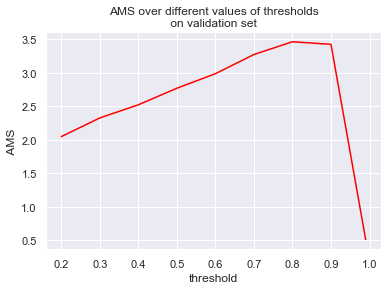

In [22]:
plt.title  ("AMS over different values of thresholds\n on validation set ")
plt.xlabel("threshold")
plt.ylabel(" AMS ")
plt.plot   ( thresholds , ls_res , color="red" )

In [23]:
num_round = 100 
ls_res = [ ]

thresholds =  np.arange ( 0.8 , 0.9 , 0.01 )
for th in  thresholds  : 
    print(" threshold : " , th )
    clf = lgb.train(params , d_train , num_round , verbose_eval=False )
    ypred = clf.predict(X_valid)
    ams_valid = get_ams_score( W_valid  , Y_valid , ( clf.predict ( X_valid ) > th ).astype("int")  )
    ls_res.append ( ams_valid )
    print("----------------------------------------------------------------")
    
ls_res = np.array ( ls_res )

 threshold :  0.8
----------------------------------------------------------------
 threshold :  0.81
----------------------------------------------------------------
 threshold :  0.8200000000000001
----------------------------------------------------------------
 threshold :  0.8300000000000001
----------------------------------------------------------------
 threshold :  0.8400000000000001
----------------------------------------------------------------
 threshold :  0.8500000000000001
----------------------------------------------------------------
 threshold :  0.8600000000000001
----------------------------------------------------------------
 threshold :  0.8700000000000001
----------------------------------------------------------------
 threshold :  0.8800000000000001
----------------------------------------------------------------
 threshold :  0.8900000000000001
----------------------------------------------------------------


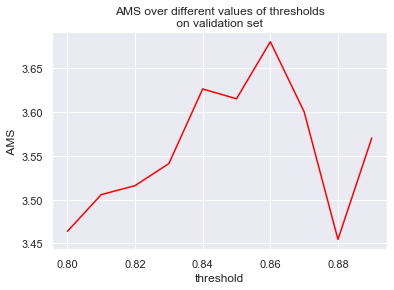

In [24]:
plt.title  ("AMS over different values of thresholds\n on validation set ")
plt.xlabel("threshold")
plt.ylabel(" AMS ")
plt.plot   ( thresholds , ls_res , color="red" )

In [26]:
th = 0.86

In [27]:
num_leaves = np.arange ( 6 , 80 )
ls_res = [ ]

for nl in num_leaves : 
    print ("num_leaves : ",nl)
    params["num_leaves"] = nl
    clf = lgb.train(params , d_train , num_round , verbose_eval=False )
    ypred = clf.predict(X_valid)
    ams_valid = get_ams_score( W_valid  , Y_valid , ( clf.predict ( X_valid ) > th ).astype("int")  )
    ls_res.append ( ams_valid )
    print("----------------------------------------------------------------")
    
ls_res = np.array ( ls_res )

num_leaves :  6
----------------------------------------------------------------
num_leaves :  7
----------------------------------------------------------------
num_leaves :  8
----------------------------------------------------------------
num_leaves :  9
----------------------------------------------------------------
num_leaves :  10
----------------------------------------------------------------
num_leaves :  11
----------------------------------------------------------------
num_leaves :  12
----------------------------------------------------------------
num_leaves :  13
----------------------------------------------------------------
num_leaves :  14
----------------------------------------------------------------
num_leaves :  15
----------------------------------------------------------------
num_leaves :  16
----------------------------------------------------------------
num_leaves :  17
----------------------------------------------------------------
num_leaves :  18
---

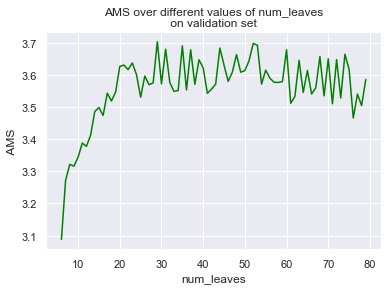

In [28]:
plt.title  ("AMS over different values of num_leaves\n on validation set ")
plt.xlabel("num_leaves")
plt.ylabel(" AMS ")
plt.plot   ( num_leaves , ls_res , color="green" )

In [29]:
np.array (ls_res).argmax()+6

29

In [30]:
params["num_leaves"] = 29

In [31]:
lambda_l1s = [ -6 , -5 , -4 , -3  , -2 , -1 , 0 , 1 , 2 ]
th = 0.86 
ls_res = [ ]

for reg1 in lambda_l1s : 
    print ("reg1 : " , 10 ** reg1 )
    params["lambda_l1"] = 10 ** reg1
    clf = lgb.train(params , d_train , num_round , verbose_eval=False )
    ypred = clf.predict(X_valid)
    ams_valid = get_ams_score( W_valid  , Y_valid , ( clf.predict ( X_valid ) > th ).astype("int")  )
    ls_res.append ( ams_valid )
    print("----------------------------------------------------------------")
    
ls_res = np.array ( ls_res )

reg1 :  1e-06
----------------------------------------------------------------
reg1 :  1e-05
----------------------------------------------------------------
reg1 :  0.0001
----------------------------------------------------------------
reg1 :  0.001
----------------------------------------------------------------
reg1 :  0.01
----------------------------------------------------------------
reg1 :  0.1
----------------------------------------------------------------
reg1 :  1
----------------------------------------------------------------
reg1 :  10
----------------------------------------------------------------
reg1 :  100
----------------------------------------------------------------


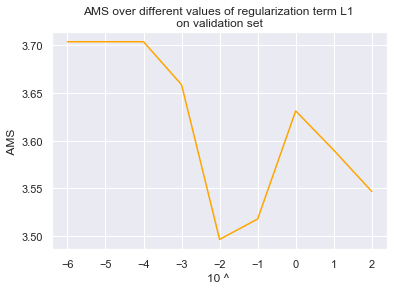

In [32]:
plt.title  ("AMS over different values of regularization term L1 \n on validation set ")
plt.xlabel("10 ^ ")
plt.ylabel(" AMS ")
plt.plot   ( lambda_l1s , ls_res , color="orange" )

In [33]:
lambda_l1s = [ -6 , -5 , -4 , -3  , -2 , -1 , 0 , 1 , 2 ]
th = 0.86 
ls_res = [ ]

for reg1 in lambda_l1s : 
    print ("reg1 : " , 10 ** reg1 )
    params["lambda_l2"] = 10 ** reg1
    clf = lgb.train(params , d_train , num_round , verbose_eval=False )
    ypred = clf.predict(X_valid)
    ams_valid = get_ams_score( W_valid   , Y_valid , ( clf.predict ( X_valid ) > th ).astype("int")  )
    ls_res.append ( ams_valid )
    print("----------------------------------------------------------------")
    
ls_res = np.array ( ls_res )

reg1 :  1e-06
----------------------------------------------------------------
reg1 :  1e-05
----------------------------------------------------------------
reg1 :  0.0001
----------------------------------------------------------------
reg1 :  0.001
----------------------------------------------------------------
reg1 :  0.01
----------------------------------------------------------------
reg1 :  0.1
----------------------------------------------------------------
reg1 :  1
----------------------------------------------------------------
reg1 :  10
----------------------------------------------------------------
reg1 :  100
----------------------------------------------------------------


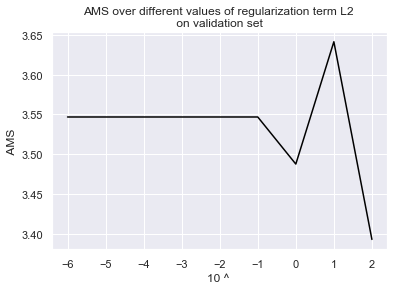

In [34]:
plt.title  ("AMS over different values of regularization term L2 \n on validation set ")
plt.xlabel("10 ^ ")
plt.ylabel(" AMS ")
plt.plot   ( lambda_l1s , ls_res , color="black" )

**boosting parameter**

boosting  :  gdbt
----------------------------------------------------------------
boosting  :  rf
----------------------------------------------------------------
boosting  :  dart
----------------------------------------------------------------
boosting  :  gauss
----------------------------------------------------------------


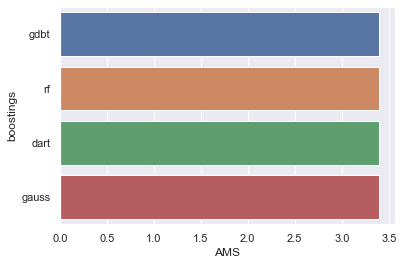

In [35]:
boostings = ["gdbt",'rf','dart',"gauss"]
ls_res = [ ]

for boost in boostings : 
    print ("boosting  : " , boost )
    params["boosting "] = boost
    clf = lgb.train(params , d_train , num_round , verbose_eval=False )
    
    ypred = clf.predict(X_valid)
    ams_valid = get_ams_score( W_valid   , Y_valid , ( clf.predict ( X_valid ) > th ).astype("int")  )
    ls_res.append ( ams_valid )
    print("----------------------------------------------------------------")
    
ls_res = np.array ( ls_res )

sns.barplot ( y ="boostings" ,  x = "AMS" , data= pd.DataFrame ( {"boostings" : boostings , "AMS" : ls_res } ) )

**is_unbalance**

In [36]:
ls_res = [ ]

for is_unbalance in [False,True] : 
    print ("is_unbalance  : " , is_unbalance )
    params["is_unbalance"] = is_unbalance
    clf = lgb.train(params , d_train , num_round  )
    ypred = clf.predict(X_valid)
    ams_valid = get_ams_score( W_valid   , Y_valid , ( clf.predict ( X_valid ) > th ).astype("int")  )
    ls_res.append ( ams_valid )
    print("----------------------------------------------------------------")
    
ls_res = np.array ( ls_res )

is_unbalance  :  False
----------------------------------------------------------------
is_unbalance  :  True
----------------------------------------------------------------


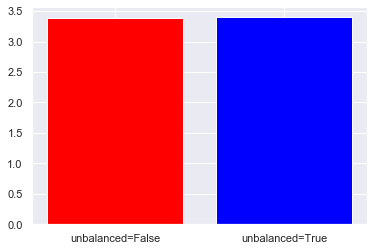

In [37]:
plt.bar( [0,1] , ls_res , color=["red","blue"] )
plt.xticks( [0,1] , ('unbalanced=False', 'unbalanced=True'))
plt.show()

**max depth** 

In [38]:
max_depths = np.arange ( 2 , 30 , 1 )
ls_res = [ ]

for max_depth in max_depths : 
    print ("max_depth : ",max_depth)
    params["max_depth"] = max_depth
    clf = lgb.train(params , d_train , num_round  )
    ypred = clf.predict(X_valid)
    ams_valid = get_ams_score( W_valid  , Y_valid , ( clf.predict ( X_valid ) > th ).astype("int")  )
    ls_res.append ( ams_valid )
    print("----------------------------------------------------------------")
    
ls_res = np.array ( ls_res )

max_depth :  2
----------------------------------------------------------------
max_depth :  3
----------------------------------------------------------------
max_depth :  4
----------------------------------------------------------------
max_depth :  5
----------------------------------------------------------------
max_depth :  6
----------------------------------------------------------------
max_depth :  7
----------------------------------------------------------------
max_depth :  8
----------------------------------------------------------------
max_depth :  9
----------------------------------------------------------------
max_depth :  10
----------------------------------------------------------------
max_depth :  11
----------------------------------------------------------------
max_depth :  12
----------------------------------------------------------------
max_depth :  13
----------------------------------------------------------------
max_depth :  14
--------------------

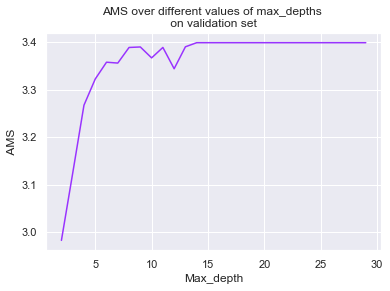

In [40]:
plt.title  ("AMS over different values of max_depths \n on validation set ")
plt.xlabel("Max_depth")
plt.ylabel(" AMS ")
plt.plot   ( max_depths , ls_res , color=(153/255, 51/255, 255/255))

In [60]:
params = { }

params['objective'] = 'binary'
params['metric'] = 'auc'
params['early_stopping_round '] = 5
params['learning_rate'] = 0.1
params["num_leaves"] = 29
params['max_depth']  = 14

num_round = 100

th = 0.86

**min_data_in_leaf** 

In [25]:
min_data_in_leafs = np.arange ( 1 , 50 , 1 )
ls_res = [ ]

for min_data_in_leaf in min_data_in_leafs : 
    print ("min_data_in_leaf : ",min_data_in_leaf)
    params["min_data_in_leaf"] = min_data_in_leaf
    clf = lgb.train(params , d_train , num_round  )
    ypred = clf.predict(X_valid)
    ams_valid = get_ams_score( W_valid  , Y_valid , ( clf.predict ( X_valid ) > th ).astype("int")  )
    ls_res.append ( ams_valid )
    print("----------------------------------------------------------------")
    
ls_res = np.array ( ls_res )

min_data_in_leaf :  1
----------------------------------------------------------------
min_data_in_leaf :  2
----------------------------------------------------------------
min_data_in_leaf :  3
----------------------------------------------------------------
min_data_in_leaf :  4
----------------------------------------------------------------
min_data_in_leaf :  5
----------------------------------------------------------------
min_data_in_leaf :  6
----------------------------------------------------------------
min_data_in_leaf :  7
----------------------------------------------------------------
min_data_in_leaf :  8
----------------------------------------------------------------
min_data_in_leaf :  9
----------------------------------------------------------------
min_data_in_leaf :  10
----------------------------------------------------------------
min_data_in_leaf :  11
----------------------------------------------------------------
min_data_in_leaf :  12
------------------

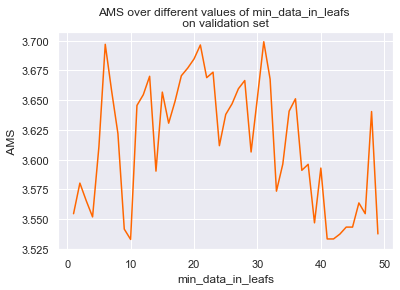

In [26]:
plt.title  ("AMS over different values of min_data_in_leafs \n on validation set ")
plt.xlabel("min_data_in_leafs")
plt.ylabel(" AMS ")
plt.plot   ( min_data_in_leafs , ls_res , color=np.array([255, 102, 0])/255 )

In [32]:
(ls_res.argsort()+1)[::-1]

array([31,  6, 21, 20, 19, 23, 18, 13, 22, 32, 28, 27,  7, 15, 12, 30, 36,
       17, 26, 11, 35, 48, 25, 16,  8, 24,  5, 29, 34, 38, 40, 37, 14,  2,
       33,  3, 46, 47,  1,  4, 39, 44, 45,  9, 49, 43, 41, 42, 10],
      dtype=int64)

In [38]:
params["min_data_in_leaf"] = 21

**weights on the objective function** 

In [564]:
scale_pos_weights = np.linspace( 0.2 , 1.0 , num=17 , endpoint=True )
scale_pos_weights

array([0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 ,
       0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [565]:

ls_res = [ ]

for scale_pos_weight  in scale_pos_weights : 
    print ("scale_pos_weight  : ",scale_pos_weight )
    params["scale_pos_weight"] = scale_pos_weight 
    
    clf = lgb.train(params , d_train , num_round  )
    ypred = clf.predict(X_valid)
    ams_valid = get_ams_score( W_valid  , Y_valid , ( clf.predict ( X_valid ) > th ).astype("int")  )
    ls_res.append ( ams_valid )
    print("----------------------------------------------------------------")
    
ls_res = np.array ( ls_res )

scale_pos_weight  :  0.2
----------------------------------------------------------------
scale_pos_weight  :  0.25
----------------------------------------------------------------
scale_pos_weight  :  0.30000000000000004
----------------------------------------------------------------
scale_pos_weight  :  0.35000000000000003
----------------------------------------------------------------
scale_pos_weight  :  0.4
----------------------------------------------------------------
scale_pos_weight  :  0.45
----------------------------------------------------------------
scale_pos_weight  :  0.5
----------------------------------------------------------------
scale_pos_weight  :  0.55
----------------------------------------------------------------
scale_pos_weight  :  0.6000000000000001
----------------------------------------------------------------
scale_pos_weight  :  0.65
----------------------------------------------------------------
scale_pos_weight  :  0.7
------------------------

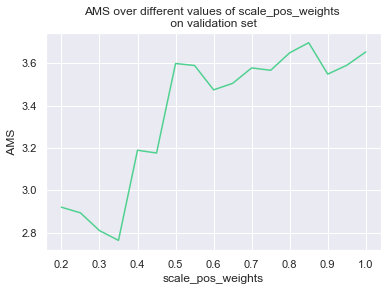

In [568]:
plt.title  ("AMS over different values of scale_pos_weights \n on validation set ")
plt.xlabel("scale_pos_weights")
plt.ylabel(" AMS ")
plt.plot   ( scale_pos_weights , ls_res , color=np.array([79, 209, 144])/255 )

In [570]:
scale_pos_weights = np.linspace( 0.7 , 1.0 , num=31 , endpoint=True )
scale_pos_weights

array([0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 ,
       0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91,
       0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  ])

In [571]:

ls_res = [ ]

for scale_pos_weight  in scale_pos_weights : 
    print ("scale_pos_weight  : ",scale_pos_weight )
    params["scale_pos_weight"] = scale_pos_weight 
    
    clf = lgb.train(params , d_train , num_round  )
    ypred = clf.predict(X_valid)
    ams_valid = get_ams_score( W_valid  , Y_valid , ( clf.predict ( X_valid ) > th ).astype("int")  )
    ls_res.append ( ams_valid )
    print("----------------------------------------------------------------")
    
ls_res = np.array ( ls_res )

scale_pos_weight  :  0.7
----------------------------------------------------------------
scale_pos_weight  :  0.71
----------------------------------------------------------------
scale_pos_weight  :  0.72
----------------------------------------------------------------
scale_pos_weight  :  0.73
----------------------------------------------------------------
scale_pos_weight  :  0.74
----------------------------------------------------------------
scale_pos_weight  :  0.75
----------------------------------------------------------------
scale_pos_weight  :  0.76
----------------------------------------------------------------
scale_pos_weight  :  0.77
----------------------------------------------------------------
scale_pos_weight  :  0.78
----------------------------------------------------------------
scale_pos_weight  :  0.79
----------------------------------------------------------------
scale_pos_weight  :  0.7999999999999999
---------------------------------------------------

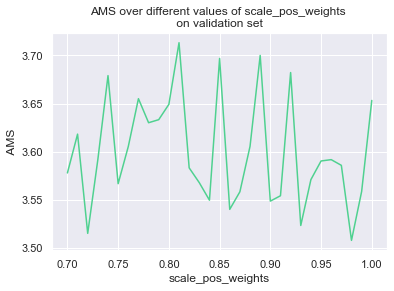

In [572]:
plt.title  ("AMS over different values of scale_pos_weights \n on validation set ")
plt.xlabel("scale_pos_weights")
plt.ylabel(" AMS ")
plt.plot   ( scale_pos_weights , ls_res , color=np.array([79, 209, 144])/255 )

In [77]:
num_rounds = np.arange ( 95 , 116 , 1 )

ls_res = [ ]

for num_round  in num_rounds : 
    
    clf = lgb.train(params , d_train , num_round  )
    ypred = clf.predict(X_valid)
    ams_valid = get_ams_score( W_valid  , Y_valid , ( clf.predict ( X_valid ) > th ).astype("int")  )
    ls_res.append ( ams_valid )
    print("----------------------------------------------------------------")
    
ls_res = np.array ( ls_res )

----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
-------------------------

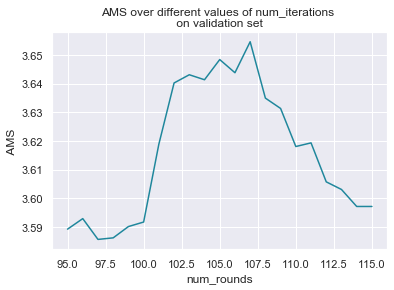

In [78]:
plt.title  ("AMS over different values of num_iterations \n on validation set ")
plt.xlabel("num_rounds")
plt.ylabel(" AMS ")
plt.plot   ( num_rounds , ls_res , color=np.array([31, 135, 156])/255 )

In [81]:
ls_res.argmax()+95

107

**Final Model**

In [61]:
params = { }

params['objective'] = 'binary'
params['early_stopping_round '] = 5
params['learning_rate'] = 0.1
params["num_leaves"] = 29
params['max_depth']  = 14
params["min_data_in_leaf"] = 31
params["scale_pos_weight"] = 0.96
num_round = 107

th = 0.84

clf = lgb.train(params , d_train , num_round , feature_name=[ training_data.columns[i] for i in range(X_train.shape[-1])]  )

Plotting feature importances...


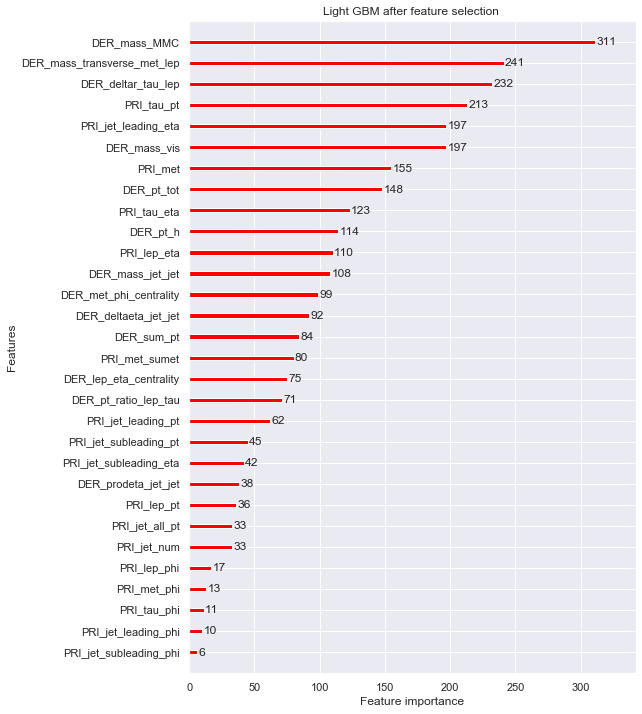

In [62]:
print('Plotting feature importances...')
lgb.plot_importance(clf, max_num_features=30 , color='red' , title='Light GBM after feature selection ' , figsize = (8 , 12 ) )
plt.show()

## Analyzing the error

**False Negative**

In [109]:
pd.options.display.max_columns = None

In [138]:
signals  = ( Y_valid == 1 ) 
signals

array([False, False, False, ...,  True, False, False])

In [155]:
Y_valid

array([0, 0, 0, ..., 1, 0, 0], dtype=int8)

In [149]:
( np.round ( clf.predict( ( X_valid ) ) , 2 ) [ : 20 ]  )

array([0.77, 0.2 , 0.14, 0.76, 0.03, 0.16, 0.03, 0.01, 0.08, 0.59, 0.54,
       0.99, 0.12, 0.12, 0.96, 0.05, 0.18, 0.15, 0.02, 0.15])

In [185]:
Y_valid_pred = ( clf.predict ( X_valid ) > 0.84 ).astype("int") 
Y_valid_pred

array([0, 0, 0, ..., 1, 0, 0])

In [215]:
false_positives = np.intersect1d ( np.nonzero(Y_valid)  , np.argwhere ( Y_valid_pred  == 0 ).ravel()  )

len(false_positives)

5115

In [209]:
pd.DataFrame ( X_valid[ false_positives ] ) 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,113.938,37.713,78.068,73.541,1.506,83.664,0.344,2.062,2.179,176.908,0.670,1.380,0.946,55.592,-1.102,-1.189,37.219,-1.132,0.873,23.319,-0.516,224.587,2.0,45.739,-1.707,2.192,38.358,-0.202,-3.017,84.097
1,80.489,11.773,57.768,1.302,-999.000,-999.000,-999.000,2.931,1.302,58.352,0.812,-1.402,-999.000,32.196,-0.641,-1.849,26.156,-0.562,1.504,9.237,0.728,61.722,0.0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
2,108.331,6.458,67.765,71.979,-999.000,-999.000,-999.000,1.840,4.887,156.480,0.532,0.774,-999.000,58.347,-0.619,2.551,31.030,-0.688,0.711,37.678,0.522,216.405,1.0,67.102,1.205,-1.683,-999.000,-999.000,-999.000,67.102
3,133.531,83.943,114.705,47.611,-999.000,-999.000,-999.000,2.437,47.611,104.640,2.270,-1.410,-999.000,31.995,-1.444,-1.085,72.644,0.148,-2.930,31.991,1.240,233.207,0.0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000
4,92.048,20.402,50.678,85.481,-999.000,-999.000,-999.000,2.010,11.860,155.316,1.226,1.330,-999.000,26.946,1.113,-2.820,33.046,1.351,-0.824,53.839,-1.312,252.596,1.0,95.323,0.018,1.769,-999.000,-999.000,-999.000,95.323
5,117.006,33.111,92.202,44.030,-999.000,-999.000,-999.000,2.239,1.289,147.601,1.424,-1.303,-999.000,42.271,-0.951,-2.984,60.188,-0.559,-0.780,11.742,0.565,111.534,1.0,45.142,-0.353,1.837,-999.000,-999.000,-999.000,45.142
6,109.536,9.823,50.979,253.375,0.162,85.791,3.169,1.010,25.558,373.485,1.417,1.143,0.000,42.793,1.732,2.870,60.647,1.104,2.080,159.149,2.180,383.037,2.0,181.952,1.701,-0.793,88.093,1.863,-1.352,270.046
7,-999.000,80.379,82.957,12.866,-999.000,-999.000,-999.000,2.335,12.866,70.660,0.972,-1.405,-999.000,35.830,-2.254,0.137,34.831,-0.620,1.804,58.946,-2.297,127.851,0.0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
8,93.535,48.695,54.682,61.069,-999.000,-999.000,-999.000,2.261,24.414,144.473,1.016,1.369,-999.000,29.849,-0.384,0.404,30.327,-0.589,2.656,37.173,1.034,169.868,1.0,84.298,-1.818,-2.003,-999.000,-999.000,-999.000,84.298
9,116.454,11.747,61.239,84.830,-999.000,-999.000,-999.000,2.029,0.978,156.697,0.767,1.234,-999.000,41.149,-1.645,0.419,31.544,-1.579,2.447,55.554,2.166,179.230,1.0,84.004,-1.660,-1.353,-999.000,-999.000,-999.000,84.004


In [224]:
miss_cols = [4,5,6,12,23,24,25,26,27,28]

arr = np.arange(X_valid.shape[0])


for col in miss_cols : 
    arr = np.intersect1d ( arr , np.argwhere( X_valid[:,col] == -999 ).ravel()   )
    
arr = np.intersect1d ( arr , false_positives ) 

In [226]:
pd.DataFrame ( X_valid[ arr ] ) 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,80.489,11.773,57.768,1.302,-999.0,-999.0,-999.0,2.931,1.302,58.352,0.812,-1.402,-999.0,32.196,-0.641,-1.849,26.156,-0.562,1.504,9.237,0.728,61.722,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0
1,133.531,83.943,114.705,47.611,-999.0,-999.0,-999.0,2.437,47.611,104.640,2.270,-1.410,-999.0,31.995,-1.444,-1.085,72.644,0.148,-2.930,31.991,1.240,233.207,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-0.0
2,-999.000,80.379,82.957,12.866,-999.0,-999.0,-999.0,2.335,12.866,70.660,0.972,-1.405,-999.0,35.830,-2.254,0.137,34.831,-0.620,1.804,58.946,-2.297,127.851,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0
3,101.476,6.909,81.402,26.888,-999.0,-999.0,-999.0,3.599,26.888,52.396,1.321,-1.284,-999.0,22.579,-0.291,-1.363,29.818,-2.336,1.959,20.038,1.676,104.276,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0
4,-999.000,63.706,81.082,21.233,-999.0,-999.0,-999.0,2.726,21.233,69.961,1.033,-1.413,-999.0,34.414,-0.335,-2.641,35.547,-1.620,1.238,45.749,-0.584,155.965,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0
5,92.134,12.370,62.062,26.026,-999.0,-999.0,-999.0,3.274,26.026,56.622,1.345,-1.414,-999.0,24.145,-2.462,1.603,32.477,-1.540,-1.539,18.440,-2.050,94.757,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0
6,92.763,53.847,71.296,26.986,-999.0,-999.0,-999.0,2.441,26.986,62.736,1.347,-0.907,-999.0,26.728,0.589,-1.645,36.008,-0.867,0.314,20.163,-2.748,151.969,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0
7,-999.000,42.813,57.347,0.326,-999.0,-999.0,-999.0,2.234,0.326,64.644,0.717,-1.395,-999.0,37.644,-0.846,2.549,27.000,-0.786,0.316,30.219,-1.378,44.387,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0
8,78.797,2.275,51.145,39.262,-999.0,-999.0,-999.0,2.485,39.262,53.738,1.273,1.114,-999.0,23.637,0.269,1.701,30.101,0.613,-2.121,23.803,-2.206,115.110,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0
9,115.450,77.840,74.104,19.748,-999.0,-999.0,-999.0,3.066,19.748,74.412,1.547,-1.408,-999.0,29.218,1.322,2.424,45.194,0.915,-0.821,35.184,1.882,114.731,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-0.0


In [277]:
neg_cols = [11,14,17,18,20]
miss_cols = [4,5,6,12,23,24,25,26,27,28]

arr = np.arange(X_valid.shape[0])

for col in miss_cols : 
    arr = np.intersect1d ( arr , np.argwhere( X_valid[:,col] == -999 ).ravel()   )

arr = np.intersect1d ( arr , np.argwhere( X_valid[:, 8] <  3 ).ravel()   )
    
len(arr)

3241

In [278]:


Y_valid_pred =  ( clf.predict ( X_valid ) > 0.84 ).astype("int") 
print ('   - AMS based on Test Data      :',get_ams_score( W_valid , Y_valid , Y_valid_pred ) )

   - AMS based on Test Data      : 3.653231124016525


In [283]:
Y_valid_pred[arr] = 1
print ('   - AMS based on Test Data      :',get_ams_score( W_valid , Y_valid , Y_valid_pred ) )

   - AMS based on Test Data      : 3.2550561379706844


## Unseen data

In [63]:
params = { }

params['objective'] = 'binary'
params['early_stopping_round '] = 5
params['learning_rate'] = 0.1
params["num_leaves"] = 29
params['max_depth']  = 14
params["min_data_in_leaf"] = 31
params["scale_pos_weight"] = 0.96
num_round = 107

th = 0.84

clf = lgb.train(params , d_train , num_round  )

print ('   - AMS based on Test Data      :',get_ams_score( W_test , Y_test , 
                                          ( clf.predict ( X_test ) > 0.84 ).astype("int")  ))



   - AMS based on Test Data      : 3.542729137990131


In [38]:
precision_recall_fscore_support ( Y_test , ( clf.predict ( X_test ) > 0.84 ).astype("int")  )

(array([0.75386649, 0.93081624]),
 array([0.98558545, 0.37604702]),
 array([0.85429189, 0.53568064]),
 array([65975, 34025], dtype=int64))

In [64]:
clf.save_model('model.txt')

# Testing on both private and public leaderboard ( 550 000 test example ) 

In [4]:
training_data  = data_df [ data_df['KaggleSet'] =='t' ].rename({'KaggleWeight' : 'Weight' } , axis = 1 )
training_data = training_data.drop(['KaggleSet' ], axis = 1)

Y_train = ( np.array ( training_data['Label'] ) =='s' ).astype(np.int8)

training_data = training_data.drop([ 'Label' ], axis = 1)  

training_data.head(3)

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight
0,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,...,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653
1,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,125.157,...,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584
2,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,197.814,...,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389


In [5]:
whole_ldboard_data  = data_df [ (data_df['KaggleSet'] =='v') | (data_df['KaggleSet'] =='b')  ].rename({'KaggleWeight' : 'Weight' } , axis = 1 )
whole_ldboard_data = whole_ldboard_data.drop(['KaggleSet' ], axis = 1)

Y_huge_test = ( np.array ( whole_ldboard_data['Label'] ) =='s' ).astype(np.int8)

whole_ldboard_data = whole_ldboard_data.drop([ 'Label' ], axis = 1)  

whole_ldboard_data.head(3)

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight
250000,-999.000,79.589,23.916,3.036,-999.0,-999.0,-999.0,0.903,3.036,56.018,...,98.556,0,-999.000,-999.000,-999.000,-999.0,-999.0,-999.0,-0.000,11.246677
250001,106.398,67.490,87.949,49.994,-999.0,-999.0,-999.0,2.048,2.679,132.865,...,176.251,1,47.575,-0.553,-0.849,-999.0,-999.0,-999.0,47.575,1.421938
250002,117.794,56.226,96.358,4.137,-999.0,-999.0,-999.0,2.755,4.137,97.600,...,111.505,0,-999.000,-999.000,-999.000,-999.0,-999.0,-999.0,0.000,0.010415


In [6]:
X_train = training_data.values
X_test  = whole_ldboard_data.values

# renormalizing the weights for consistency 
W_train = X_train [:,-1]
W_test  = X_test  [:,-1] 


X_train = X_train [:,:-1]
X_test  = X_test  [:,:-1]

In [7]:
X_train.shape

(250000, 30)

In [8]:
X_test.shape

(550000, 30)

In [9]:
d_train = lgb.Dataset(X_train, label=Y_train)

In [10]:
# params = { }

# params['objective'] = 'binary'
# params['early_stopping_round '] = 5
# params['learning_rate'] = 0.1
# params["num_leaves"] = 29
# params['max_depth']  = 14
# params["min_data_in_leaf"] = 31
# params["scale_pos_weight"] = 0.96
# num_round = 107

# th = 0.84

# clf = lgb.train(params , d_train , num_round  , feature_name=[ training_data.columns[i] for i in range(X_train.shape[-1])]  )

In [11]:
clf = lgb.Booster(model_file='model.txt') 

In [12]:
print (' FINAL FINAL AMS based on Test Data      :',get_ams_score( W_test , Y_huge_test , 
                                          ( clf.predict ( X_test ) > 0.84 ).astype("int")  ))

 FINAL FINAL AMS based on Test Data      : 5.028462231430036


Plotting feature importances...


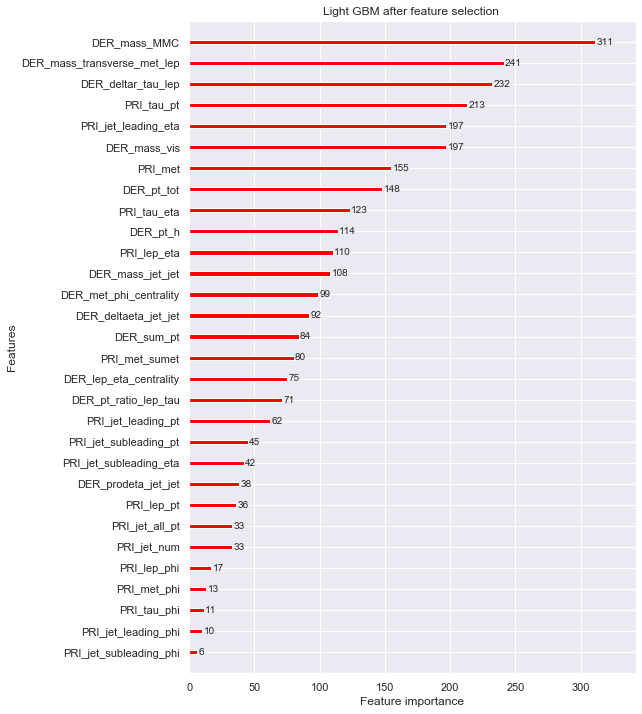

In [13]:
print('Plotting feature importances...')
lgb.plot_importance(clf, max_num_features=30 , color='red' , title='Light GBM after feature selection ' , figsize = (8 , 12 ) )
plt.show()

## Deep Learning

**Code removed , no significant results !!!!**

## Kaggle submission

In [14]:
submission_file = pd.read_csv ( "data/random_submission.csv" )

In [15]:
submission_file.head()

,EventId,RankOrder,Class
0,350000,416957,b
1,350001,89624,b
2,350002,519845,b
3,350003,510885,s
4,350004,455944,s


In [16]:
Y_pred = clf.predict ( X_test ) > 0.84

submission_file['RankOrder'] = clf.predict ( X_test )

submission_file = submission_file.rename({'RankOrder':'Prediction Probability'} , axis = 1 )
submission_file.head()

,EventId,Prediction Probability,Class
0,350000,0.006178,b
1,350001,0.120974,b
2,350002,0.540855,b
3,350003,0.890111,s
4,350004,0.023132,s


In [17]:
clf.predict ( X_test )

array([0.0061782 , 0.12097355, 0.54085477, ..., 0.04701483, 0.36271752,
       0.18825824])

In [18]:
RankOrder = np.argsort(clf.predict ( X_test ))[::-1]

RankOrder

array([257348, 215595,  99209, ..., 404919, 440410, 441214], dtype=int64)

In [19]:
Class = np.where ( Y_pred == 1 , 's' , 'b' )

Class

array(['b', 'b', 'b', ..., 'b', 'b', 'b'], dtype='<U1')

In [20]:
submission_file.columns

Index(['EventId', 'Prediction Probability', 'Class'], dtype='object')

In [21]:
submission_file['Prediction Probability'] = RankOrder + 1

submission_file = submission_file.rename({'Prediction Probability':'RankOrder'} , axis = 1 )

submission_file['Class'] = Class

In [22]:
submission_file.head()

,EventId,RankOrder,Class
0,350000,257349,b
1,350001,215596,b
2,350002,99210,b
3,350003,68026,s
4,350004,413813,b


In [23]:
submission_file.to_csv("data/final_submission.csv" , index=False)